In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime

import sys
sys.path.append('../lib/')
from blood_lib import import_pbc, learning_curves

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

2023-05-14 11:43:07.448543: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.__version__

'2.12.0'

In [3]:
path = '../Data/PBC_8cat_masked/'

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    image_size=(128, 128),
    labels='inferred',
    interpolation='bicubic',
    label_mode='categorical',
    validation_split=0.20,
    batch_size=32,
    subset='both',
    shuffle=True,
    seed=44
)
class_names = train_ds.class_names
num_classes = len(class_names)
train_ds, test_ds = tf.keras.utils.split_dataset(train_ds, left_size=0.8)
print('train batch :', tf.data.Dataset.cardinality(train_ds).numpy())
print('val batch :', tf.data.Dataset.cardinality(val_ds).numpy())
print('test batch :', tf.data.Dataset.cardinality(test_ds).numpy())
print('classes :', class_names)
print('num_classes :', num_classes)

Found 17092 files belonging to 8 classes.
Using 13674 files for training.
Using 3418 files for validation.


2023-05-04 22:11:44.461160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [13674]
	 [[{{node Placeholder/_4}}]]
2023-05-04 22:11:44.461579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [13674]
	 [[{{node Placeholder/_0}}]]


train batch : 342
val batch : 107
test batch : 86
classes : ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
num_classes : 8


Calcul des class_weights

On veut "accorder plus d'attention" aux exemples d'une classe sous-représentée

In [5]:
directory = Path(path)
class_weights = {}
total = len(list(directory.glob('**/*.jpg')))
for i, class_name in enumerate(class_names):
    #print(i, class_name)
    len_i = len(list(Path(directory/class_name).glob('*.jpg')))
    print(i, len_i)
    weight_for_i = (1 / len_i) * (total / num_classes)
    #print(weight_for_i)
    class_weights[i] = weight_for_i
class_weights

0 1218
1 3117
2 1551
3 2895
4 1214
5 1420
6 3329
7 2348


{0: 1.7541050903119868,
 1: 0.6854347128649342,
 2: 1.377498388136686,
 3: 0.7379965457685664,
 4: 1.7598846787479407,
 5: 1.5045774647887324,
 6: 0.6417843196155002,
 7: 0.909923339011925}

Remarque : L'utilisation de class_weights modifie la plage de perte. Cela peut affecter la stabilité de l'entraînement en fonction de l'optimiseur. Les optimiseurs dont la taille de pas dépend de l'ampleur du gradient, comme tf.keras.optimizers.SGD , peuvent échouer. L'optimiseur utilisé ici, tf.keras.optimizers.Adam , n'est pas affecté par le changement d'échelle. Notez également qu'en raison de la pondération, les pertes totales ne sont pas comparables entre les deux modèles.

In [6]:
# Random data augmentation
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=(128, 128, 3)),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomBrightness(factor=0.001, value_range=(0,255)),
        tf.keras.layers.RandomContrast(factor=0.1)
    ])

def process_images(ds, shuffle=1000, augment=False):
    """
    Apply diverse images modification in a tf.data.Dataset
    """
    # rescale
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    ds = ds.map(lambda x, y: (normalization_layer(x), y))
    # shuffle
    if shuffle != None:
        ds = ds.shuffle(shuffle)
    # augment
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y))
    return ds

train_ds = process_images(train_ds, shuffle=100, augment=True)
val_ds = process_images(val_ds, shuffle=None, augment=False)
test_ds = process_images(test_ds, shuffle=None, augment=False)

2023-05-04 22:12:48.545414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype resource
	 [[{{node Placeholder/_14}}]]
2023-05-04 22:12:48.545888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_16' with dtype resource
	 [[{{node Placeholder/_16}}]]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping

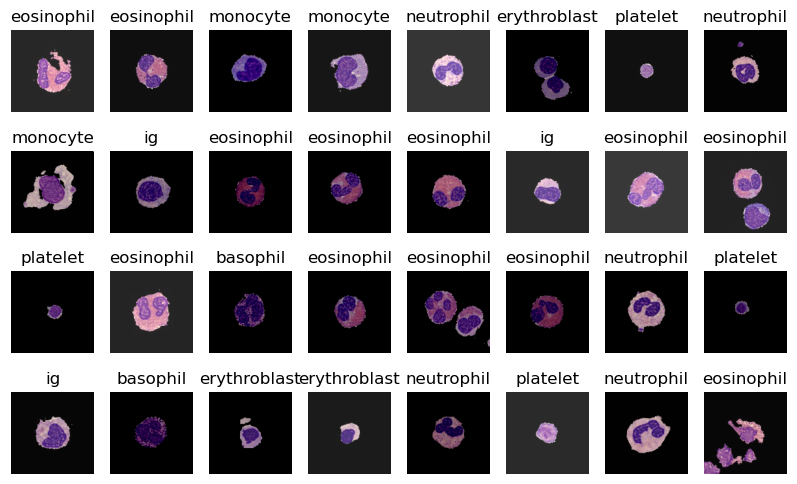

In [7]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10,6))
for i in range(32):
  ax = plt.subplot(4, 8, i + 1)
  plt.imshow(image_batch[i].numpy())
  plt.title(class_names[np.argmax(label_batch[i])])
  plt.axis("off")

In [8]:
import keras
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras import backend as K
from keras.applications.vgg16 import VGG16

# Modèle VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3)) 
# Freezer les couches du VGG16
for layer in base_model.layers: 
    layer.trainable = False

model = Sequential()
model.add(base_model) # Ajout du modèle VGG16
model.add(Flatten()) 
model.add(Dense(2048,activation='relu'))
model.add(Dense(1028, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax')) # model.add(Dense(11 +1, activation='softmax')) ??

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 2048)              16779264  
                                                                 
 dense_1 (Dense)             (None, 1028)              2106372   
                                                                 
 dense_2 (Dense)             (None, 512)               526848    
                                                                 
 dense_3 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 34,131,276
Trainable params: 19,416,588


In [9]:
epochs=50
log_dir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             TensorBoard(log_dir=log_dir, histogram_freq=1)]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weights
)

2023-05-04 22:13:44.102012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_16' with dtype resource
	 [[{{node Placeholder/_16}}]]
2023-05-04 22:13:44.102575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype float and shape [8]
	 [[{{node Placeholder/_19}}]]


Epoch 1/50
342/342 [==============================] - ETA: 0s - loss: 0.9082 - accuracy: 0.6713

2023-05-04 22:21:52.983632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3418]
	 [[{{node Placeholder/_4}}]]
2023-05-04 22:21:52.984021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3418]
	 [[{{node Placeholder/_4}}]]


342/342 [==============================] - 623s 2s/step - loss: 0.9082 - accuracy: 0.6713 - val_loss: 0.6291 - val_accuracy: 0.7692
Epoch 2/50
342/342 [==============================] - 573s 2s/step - loss: 0.5692 - accuracy: 0.7891 - val_loss: 0.5164 - val_accuracy: 0.7774
Epoch 3/50
342/342 [==============================] - 548s 2s/step - loss: 0.4762 - accuracy: 0.8246 - val_loss: 0.4539 - val_accuracy: 0.8329
Epoch 4/50
342/342 [==============================] - 549s 2s/step - loss: 0.4523 - accuracy: 0.8346 - val_loss: 0.4208 - val_accuracy: 0.8537
Epoch 5/50
342/342 [==============================] - 548s 2s/step - loss: 0.4223 - accuracy: 0.8459 - val_loss: 0.5507 - val_accuracy: 0.7879
Epoch 6/50
342/342 [==============================] - 555s 2s/step - loss: 0.4058 - accuracy: 0.8546 - val_loss: 0.4056 - val_accuracy: 0.8444
Epoch 7/50
342/342 [==============================] - 545s 2s/step - loss: 0.3629 - accuracy: 0.8710 - val_loss: 0.4516 - val_accuracy: 0.8329
Epoch 8/50

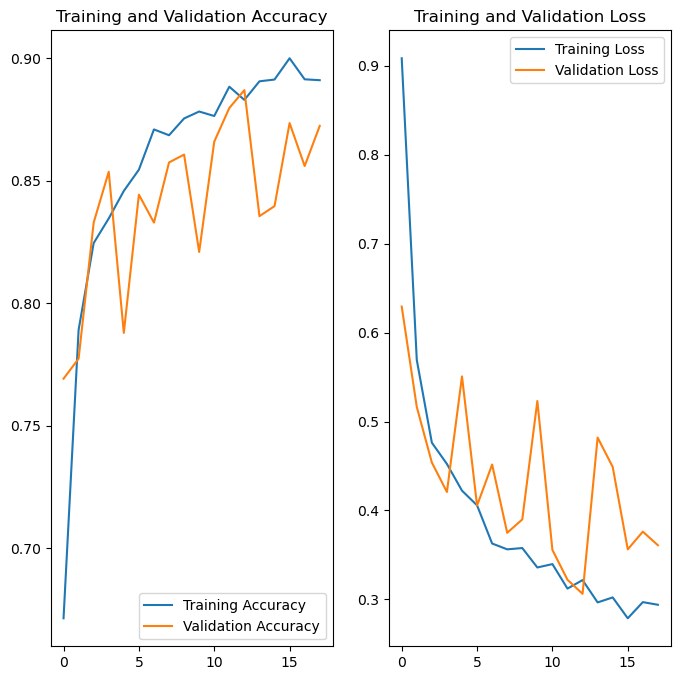

In [10]:
learning_curves(history)

In [11]:
model.save('../Models/VGG16_pt_8cat_wh_aug_masked.h5')

In [12]:
VGG16 = tf.keras.models.load_model('../Models/VGG16_pt_8cat_wh_aug_masked.h5')

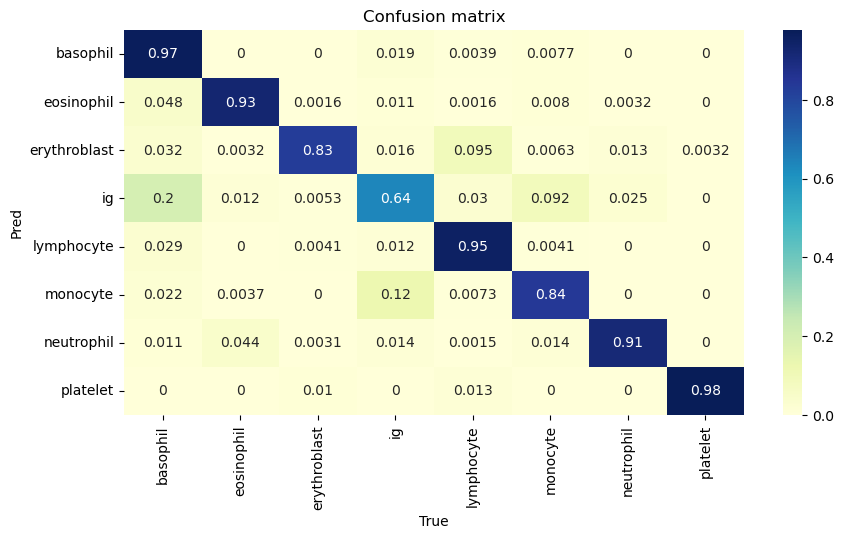

              precision    recall  f1-score   support

    basophil       0.59      0.97      0.73       259
  eosinophil       0.94      0.93      0.93       626
erythroblast       0.96      0.83      0.89       315
          ig       0.85      0.64      0.73       568
  lymphocyte       0.80      0.95      0.87       244
    monocyte       0.76      0.84      0.80       273
  neutrophil       0.97      0.91      0.94       655
    platelet       1.00      0.98      0.99       478

    accuracy                           0.87      3418
   macro avg       0.86      0.88      0.86      3418
weighted avg       0.89      0.87      0.87      3418



In [13]:
preds = VGG16.predict(
        val_ds,
        batch_size=32,
        verbose=0
)
preds = np.argmax(preds, axis=1)
true = np.concatenate([y for x, y in val_ds], axis=0)
true = np.argmax(true, axis=1)
preds_labels = [class_names[preds[x]] for x in range(len(preds))]
true_labels = [class_names[true[x]] for x in range(len(true))]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, preds_labels, normalize='true')
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(10, 5))
plt.title("Confusion matrix")
sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
plt.ylabel("Pred")
plt.xlabel("True")
plt.show()
print(classification_report(true_labels,preds_labels))

2023-05-05 07:04:35.232167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [2735,8]
	 [[{{node Placeholder/_1}}]]


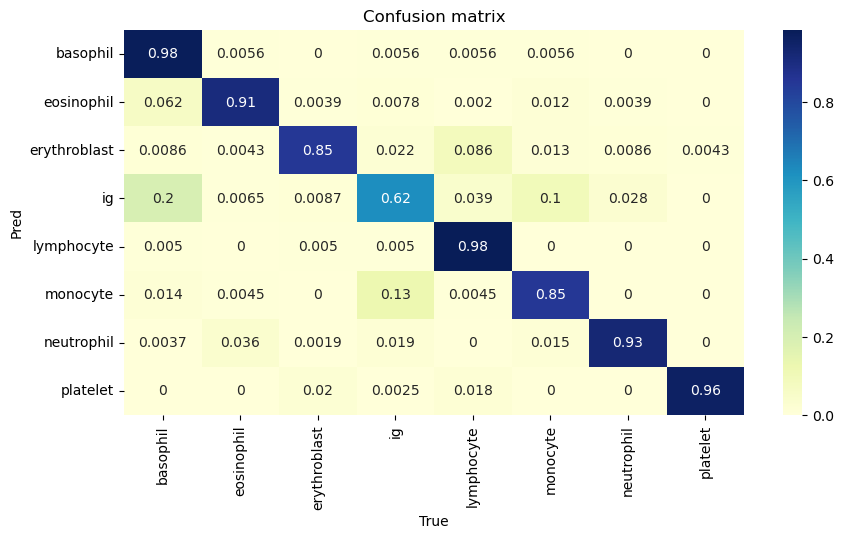

              precision    recall  f1-score   support

    basophil       0.57      0.98      0.72       178
  eosinophil       0.95      0.91      0.93       512
erythroblast       0.93      0.85      0.89       232
          ig       0.85      0.62      0.72       460
  lymphocyte       0.80      0.98      0.89       200
    monocyte       0.75      0.85      0.79       221
  neutrophil       0.97      0.93      0.95       535
    platelet       1.00      0.96      0.98       397

    accuracy                           0.87      2735
   macro avg       0.85      0.89      0.86      2735
weighted avg       0.89      0.87      0.87      2735



In [14]:
preds = VGG16.predict(test_ds, batch_size=32, verbose=0)
preds = np.argmax(preds, axis=1)
true = np.concatenate([y for x, y in test_ds], axis=0)
true = np.argmax(true, axis=1)
preds_labels = [class_names[preds[x]] for x in range(len(preds))]
true_labels = [class_names[true[x]] for x in range(len(true))]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, preds_labels, normalize='true')
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(10, 5))
plt.title("Confusion matrix")
sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
plt.ylabel("Pred")
plt.xlabel("True")
plt.show()
print(classification_report(true_labels,preds_labels))

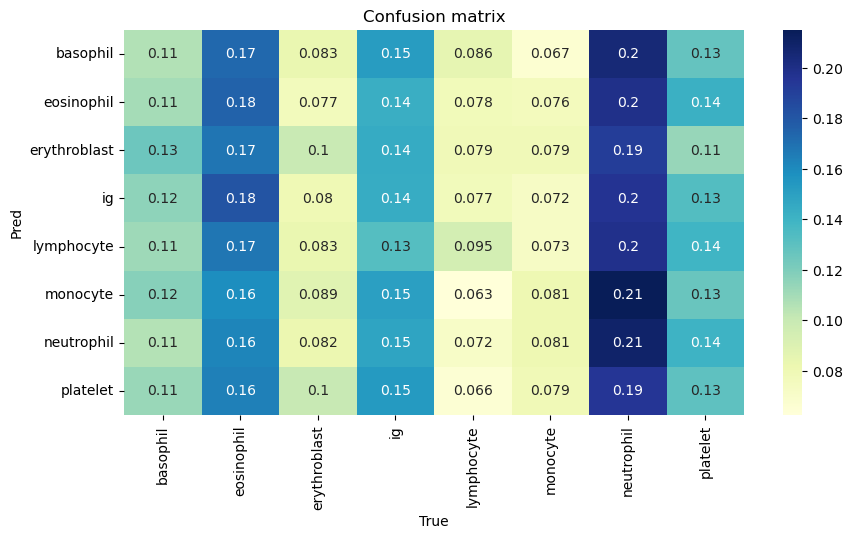

              precision    recall  f1-score   support

    basophil       0.07      0.11      0.08       781
  eosinophil       0.19      0.18      0.18      1979
erythroblast       0.11      0.10      0.10      1004
          ig       0.17      0.14      0.16      1867
  lymphocyte       0.09      0.09      0.09       770
    monocyte       0.09      0.08      0.09       926
  neutrophil       0.20      0.21      0.21      2139
    platelet       0.13      0.13      0.13      1473

    accuracy                           0.14     10939
   macro avg       0.13      0.13      0.13     10939
weighted avg       0.15      0.14      0.15     10939



In [15]:
preds = VGG16.predict(train_ds, batch_size=32, verbose=0)
preds = np.argmax(preds, axis=1)
true = np.concatenate([y for _, y in train_ds], axis=0)
true = np.argmax(true, axis=1)
preds_labels = [class_names[preds[x]] for x in range(len(preds))]
true_labels = [class_names[true[x]] for x in range(len(true))]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, preds_labels, normalize='true')
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(10, 5))
plt.title("Confusion matrix")
sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
plt.ylabel("Pred")
plt.xlabel("True")
plt.show()
print(classification_report(true_labels,preds_labels))

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")